<a href="https://colab.research.google.com/github/catastropiyush/ical/blob/main/Transformers_incontext_ar_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

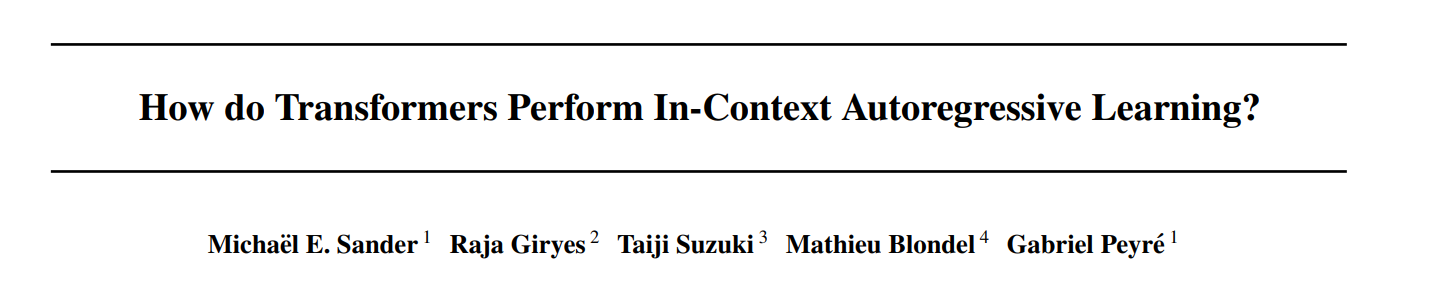

Iteration 0: Loss = 190.10830688476562
Iteration 10: Loss = 189.0259246826172
Iteration 20: Loss = 178.4429931640625
Iteration 30: Loss = 46.23472595214844
Iteration 40: Loss = 0.01425933837890625
Iteration 50: Loss = 2.47955322265625e-05
Iteration 60: Loss = -9.5367431640625e-06
Iteration 70: Loss = 4.9591064453125e-05
Iteration 80: Loss = -3.62396240234375e-05
Iteration 90: Loss = -3.62396240234375e-05
Final A: [[-0.51215154 -0.74555826  0.07589948  0.15233633 -0.07140817  0.08564384
  -0.19765066  0.14682722 -0.2094096   0.5543911 ]
 [ 0.15855654 -0.13292179 -0.25080997  0.14678054 -0.29291636  0.04358956
   0.03962858  0.48749605 -0.698246   -0.51676166]
 [-0.32780954  0.3484847   0.39616168  0.13353305 -0.22717878 -0.26933178
   0.5574417  -0.2796209  -0.4753598   0.23028538]
 [ 0.00390347 -0.19302498  0.19355422  0.21794641 -0.46807608 -0.417993
  -0.59101236 -0.52418405  0.03828495 -0.3459854 ]
 [-0.53390414 -0.21543323 -0.47257423 -0.38203564 -0.0657924  -0.53388757
   0.342035

FileNotFoundError: [Errno 2] No such file or directory: 'figures/unitary.pdf'

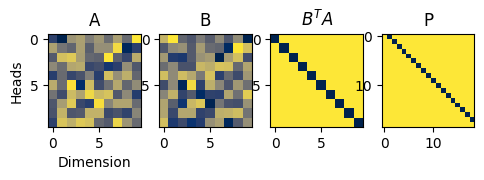

In [3]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
d = 10
T = 20
learning_rate = 0.01
num_iterations = 100
alpha = .1

# Initialize A, B, P randomly
key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, 4)
A = alpha * jax.random.normal(subkeys[0], (d, d))
B = alpha * jax.random.normal(subkeys[1], (d, d))
P = alpha * jax.random.normal(subkeys[2], (T, T))

# Loss function
def loss_function(C, p):
    """
    C: Matrix of shape (d, d)
    p: Vector of shape (T,)

    Returns the loss function for a given C and p.
    """
    d = C.shape[0]
    p_norm_squared = jnp.sum(p ** 2)
    C_norm_squared = jnp.sum(C ** 2)
    p_T_minus_1_squared = p[-2] ** 2 if p.shape[0] > 1 else 0
    sum_C_transpose_C = jnp.sum(C.T @ C)
    trace_C = jnp.trace(C)
    p_T = p[-1]
    loss = (p_norm_squared * C_norm_squared) + (p_T_minus_1_squared * sum_C_transpose_C) - (2 * trace_C * p_T) + d
    return loss

def new_loss_function(A, B, p):
    """
    A: Matrix of shape (d, d)
    B: Matrix of shape (d, d)

    Returns the loss function for a given A, B, and p.
    """
    C = B.T @ A
    return loss_function(C, p)

def final_loss(A, B, P):
    """
    A: Matrix of shape (d, d)
    B: Matrix of shape (d, d)

    Returns the total loss for a given A, B, and P."""
    total_loss = 0
    for t in range(T-1):
        p_t = P[t, :t+2]
        total_loss += new_loss_function(A, B, p_t)
    return total_loss

# Gradient function
grad_loss = jax.jit(jax.grad(final_loss, argnums=(0, 1, 2)))

# Gradient descent loop
for i in range(num_iterations):
    grad_A, grad_B, grad_P = grad_loss(A, B, P)
    A -= learning_rate * grad_A
    B -= learning_rate * grad_B
    P -= learning_rate * grad_P

    if i % 10 == 0:  # Print loss every 10 iterations
        print(f"Iteration {i}: Loss = {final_loss(A, B, P)}")

# Final parameters and loss
print("Final A:", A)
print("Final B:", B)
print("Final P:", P)
print("Final Loss:", final_loss(A, B, P))

os.makedirs('tensors', exist_ok=True)

np.save('tensors/A_unitary.npy', A)
np.save('tensors/B_unitary.npy', B)
np.save('tensors/P_unitary.npy', P)


C = np.dot(B.T, A)

p=1.1
# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, 4, figsize=(5*p, 2.5*p))

# Plot for Matrix A
axs[0].imshow(A, cmap='cividis', interpolation='nearest')
axs[0].set_title('A')
axs[0].set_xlabel('Dimension')
axs[0].set_ylabel('Heads')

# Plot for Matrix B
axs[1].imshow(B, cmap='cividis', interpolation='nearest')
axs[1].set_title('B')

# Plot for B^T * A
axs[2].imshow(C, cmap='cividis', interpolation='nearest')
axs[2].set_title('$B^{T} A$')

mask = np.triu(np.ones_like(P), k=2) # k=1 starts the mask above the diagonal

# Apply the mask to set these elements to zero
P_masked = np.where(mask, 0, P)

# Plot for Matrix P
axs[3].imshow(P_masked[:-1,:-1], cmap='cividis', interpolation='nearest')
axs[3].set_title('P')

# Show the plots
plt.savefig('unitary.pdf')

In [4]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt

In [5]:
# Load pre-trained model tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)


# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load pre-trained model

# Encode some text (replace "Your text here" with your input text)
input_text = "My name is Clara and I am?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Predict the next token
outputs = model(input_ids)
predictions = outputs[0]

# Get the predicted next token
predicted_index = torch.argmax(predictions[:, -1, :], dim=-1)
predicted_token = tokenizer.decode(predicted_index)

print("Predicted token:", predicted_token)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Predicted token:  I


In [6]:
import random
random_seed = random.randint(0, 10000)
torch.manual_seed(random_seed)

# Encode some text (add your own text here)
input_text = "My name is Clara and I am"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Create an attention mask for the inputs
attention_mask = torch.ones(input_ids.shape)

# Set the model to evaluation mode and disable gradient calculations
model.eval()
with torch.no_grad():
    # Generate predictions
    outputs = model.generate(input_ids,
                             max_length=40,  # Maximum length of the output text
                             num_return_sequences=1,  # Number of sentences to generate
                             #temperature=0.5,  # Lower is less random, higher is more random
                             # Number of highest probability tokens to keep for top-k filtering
                             #attention_mask=attention_mask,  # The attention mask
                             pad_token_id=tokenizer.eos_token_id
                            )  # Set pad token

# Decode and print the output text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


My name is Clara and I am a woman. I am a woman who is a woman. I am a woman who is a woman. I am a woman who is a woman. I am a


In [8]:
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize

# Download necessary NLTK datasets
nltk.download('gutenberg')
nltk.download('punkt_tab')

# Load text from a simple-language corpus
text = gutenberg.raw('melville-moby_dick.txt') # gutenberg.raw('austen-emma.txt')
sentences = sent_tokenize(text)

# Tokenize text into sentences

# Select 1000 random sentences
random_sentences = sentences

# Simplify each sentence (this is a placeholder - real simplification is complex)
# As an example, we split longer sentences into shorter ones
simple_sentences = ['.'.join(sent.split('.')[:2]) for sent in random_sentences]

model_name = 'gpt2-large'  # Consider using 'gpt2-medium', 'gpt2-large', or 'gpt2-xl'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
len(simple_sentences)

9852

In [11]:
cleaned_text_list = [''.join([char if char.isalpha() or char.isspace() else '' for char in text]) for text in simple_sentences]

input_ids = tokenizer(simple_sentences, return_tensors='pt', padding=True, truncation=True)

In [12]:
print(gutenberg.fileids())


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [13]:
input_ids_flatten = input_ids['input_ids'].flatten()
input_ids_flatten = input_ids_flatten[torch.where(input_ids_flatten != input_ids_flatten.max())]

#input_ids_flatten = input_ids_flatten.unique(sorted=False)

seq_lenght = 5

r = input_ids_flatten.shape[0] % seq_lenght

input_ids_flatten = input_ids_flatten[:-r]


input_ids_to_embed = input_ids_flatten.reshape(-1, seq_lenght)

#torch.save(batch_seq, 'tensors/sequences.to')

In [14]:
batch_seq = model.transformer.wte(input_ids_to_embed[:,:]).float().detach()


In [15]:
def fit_ar(sequence):
    inputs = sequence[:-1]  # All elements except the last
    outputs = sequence[1:]  # All elements except the first

    A_estimated = torch.linalg.lstsq(inputs, outputs)[0].T

    return A_estimated

def generate(A_estimated, s0, n):
    # Solve for A
    # Multiply with outputs (also transposed) and transpose the result for correct shape

    # Initialize the approximated sequence with the first element of the original sequence
    approx_sequence = [s0]

    # Compute the approximated sequence using the estimated A
    for t in range(1, n):
        next_element = torch.matmul(A_estimated, approx_sequence[-1].unsqueeze(-1)).squeeze(-1)
        approx_sequence.append(next_element)

    # Convert the list of tensors to a tensor
    approx_sequence = torch.stack(approx_sequence)
    return approx_sequence


In [16]:
batch_seq = model.transformer.wte(input_ids_to_embed[:,:]).float().detach()
batch_seq = batch_seq / batch_seq.norm(dim=-1,keepdim=True) #Normalizing each token to unit norm
N, T, d = batch_seq.shape

tensor_reshaped = batch_seq.reshape(-1, d)

# Step 2: Permute rows
permuted_indices = torch.randperm(N*T)
tensor_permuted = tensor_reshaped[permuted_indices]

# Step 3: Reshape back to (N, T, d)
rand_batch_seq = tensor_permuted.view(N, T, d)
batch_seq = batch_seq[:]
rand_batch_seq = rand_batch_seq[:]


In [17]:
batch_seq_tot = batch_seq[:10000] # modify to consider bigger datasets
batch_seq = batch_seq_tot[:,:5,:]
rand_batch_seq_tot = rand_batch_seq[:10000]
rand_batch_seq = rand_batch_seq_tot[:,:5,:]

In [18]:
approx_sequences = []
for i in range(len(batch_seq)):
    sequence = batch_seq[i]
    A = fit_ar(sequence)
    approx_sequence = generate(A, sequence[0], batch_seq_tot.shape[1])
    approx_sequences.append(approx_sequence)

In [19]:
approx_sequences = torch.stack(approx_sequences)


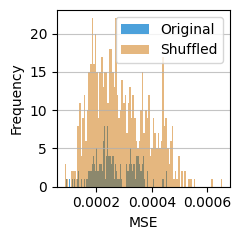

In [20]:
out = (approx_sequences - batch_seq_tot) ** 2

rand_approx_sequences = []
for i in range(len(rand_batch_seq)):
    sequence = rand_batch_seq[i]
    A = fit_ar(sequence)
    approx_sequence = generate(A, sequence[0], rand_batch_seq_tot.shape[1])
    rand_approx_sequences.append(approx_sequence)

rand_approx_sequences = torch.stack(rand_approx_sequences)

rand_out = (rand_approx_sequences - rand_batch_seq_tot) ** 2

out_mean = out.mean((1,2))
rand_out_mean = rand_out.mean((1,2))

plt.figure(figsize=(2.5, 2.5))

plt.hist(out_mean[torch.where(out_mean > 1e-12)], bins=100, color='#007acc', alpha=0.7, label='Original')

# Histogram for rand_out_mean with a different nice color
plt.hist(rand_out_mean[torch.where(rand_out_mean > 1e-12)], bins=100, color='#cc7000', alpha=0.5, label='Shuffled')

# Enhancements
plt.xlabel('MSE')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish the histograms
plt.tight_layout()  # Adjust layout to not overlap items
plt.grid(axis='y', alpha=0.75)  # Add a grid for better readability, only on y-axis
plt.savefig('hist.pdf')
plt.show()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


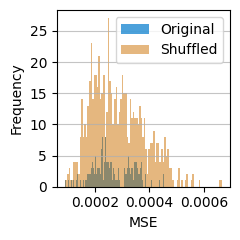

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize

# Number of sequences to consider
n = 10000

# Sequence length
seq_lenght = 5

def get_batch(n=n, seq_lenght=seq_lenght):
    """Get a batch of sequences and a shuffled version for the experiment."""
    # Download necessary NLTK datasets
    nltk.download('gutenberg')
    nltk.download('punkt')

    # Load text

    text = gutenberg.raw('melville-moby_dick.txt')
    sentences = sent_tokenize(text)
    random_sentences = sentences

    # Simplify each sentence
    simple_sentences = ['.'.join(sent.split('.')[:2]) for sent in random_sentences]

    model_name = 'gpt2-large'
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize and encode sentences in a batch

    input_ids = tokenizer(simple_sentences, return_tensors='pt', padding=True, truncation=True)

    input_ids_flatten = input_ids['input_ids'].flatten()
    input_ids_flatten = input_ids_flatten[torch.where(input_ids_flatten != input_ids_flatten.max())]

    r = input_ids_flatten.shape[0] % seq_lenght

    input_ids_flatten = input_ids_flatten[:-r]

    input_ids_to_embed = input_ids_flatten.reshape(-1, seq_lenght)


    batch_seq = model.transformer.wte(input_ids_to_embed[:,:]).float().detach()[:n]
    batch_seq = batch_seq / batch_seq.norm(dim=-1,keepdim=True) # Normalizing each token to unit norm

    N, T, d = batch_seq.shape

    tensor_reshaped = batch_seq.reshape(-1, d)

    # Permute rows
    permuted_indices = torch.randperm(N*T)
    tensor_permuted = tensor_reshaped[permuted_indices]

    # Reshape back to (N, T, d)
    rand_batch_seq = tensor_permuted.view(N, T, d)

    return batch_seq, rand_batch_seq


def fit_ar(sequence):
    """
    Fit an autoregressive model to a sequence.

    sequence: Sequence of shape (T, d)

    Returns the estimated A matrix that fits an AR process on sequence.
    """
    inputs = sequence[:-1]  # All elements except the last
    outputs = sequence[1:]  # All elements except the first

    A_estimated = torch.linalg.lstsq(inputs, outputs)[0].T

    return A_estimated

def generate(A_estimated, s0, n):
    """
    Generate a sequence from an autoregressive model.

    A_estimated: Estimated A matrix
    s0: Initial state
    n: Length of the sequence to generate

    Returns the generated sequence."""
    # Solve for A
    # Multiply with outputs (also transposed) and transpose the result for correct shape

    # Initialize the approximated sequence with the first element of the original sequence
    approx_sequence = [s0]

    # Compute the approximated sequence using the estimated A
    for _ in range(1, n):
        next_element = torch.matmul(A_estimated, approx_sequence[-1].unsqueeze(-1)).squeeze(-1)
        approx_sequence.append(next_element)

    # Convert the list of tensors to a tensor
    approx_sequence = torch.stack(approx_sequence)
    return approx_sequence


def plot_hist(batch_seq, rand_batch_seq):
    """
    Plot a histogram of the mean squared error of the original and shuffled sequences.

    batch_seq: Original batch of sequences
    rand_batch_seq: Shuffled batch of sequences

    Returns None."""
    approx_sequences = []

    for i in range(len(batch_seq)):
        sequence = batch_seq[i]
        A = fit_ar(sequence)
        approx_sequence = generate(A, sequence[0], batch_seq.shape[1])
        approx_sequences.append(approx_sequence)

    approx_sequences = torch.stack(approx_sequences)

    out = (approx_sequences - batch_seq) ** 2

    rand_approx_sequences = []
    for i in range(len(rand_batch_seq)):
        sequence = rand_batch_seq[i]
        A = fit_ar(sequence)
        approx_sequence = generate(A, sequence[0], rand_batch_seq.shape[1])
        rand_approx_sequences.append(approx_sequence)

    rand_approx_sequences = torch.stack(rand_approx_sequences)

    rand_out = (rand_approx_sequences - rand_batch_seq) ** 2

    out_mean = out.mean((1,2))
    rand_out_mean = rand_out.mean((1,2))

    plt.figure(figsize=(2.5, 2.5))
    plt.hist(out_mean[torch.where(out_mean > 1e-12)], bins=100, color='#007acc', alpha=0.7, label='Original')
    plt.hist(rand_out_mean[torch.where(rand_out_mean > 1e-12)], bins=100, color='#cc7000', alpha=0.5, label='Shuffled')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.75)
    plt.savefig('hist.pdf')

if __name__ == '__main__':
    batch_seq, rand_batch_seq = get_batch(n, seq_lenght)
    plot_hist(batch_seq, rand_batch_seq)

mu =  50
loss:  1.0
loss:  0.010117118
loss:  0.0049436498
loss:  0.0032514718
loss:  0.002403869
loss:  0.0018930077
loss:  0.0015517889
loss:  0.0013085
loss:  0.001126964
mu =  100
loss:  1.0
loss:  0.0075640087
loss:  0.0037377272
loss:  0.0024962267
loss:  0.0018841503
loss:  0.0015182303
loss:  0.0012736035
loss:  0.0010976951
mu =  200
loss:  1.0
loss:  0.005066841
loss:  0.0028227984
loss:  0.0020173278
loss:  0.0015802154
loss:  0.0012979782
loss:  0.0010981088
mu =  300
loss:  1.0
loss:  0.004389534
loss:  0.0022250034
loss:  0.0015172494
loss:  0.0011665662


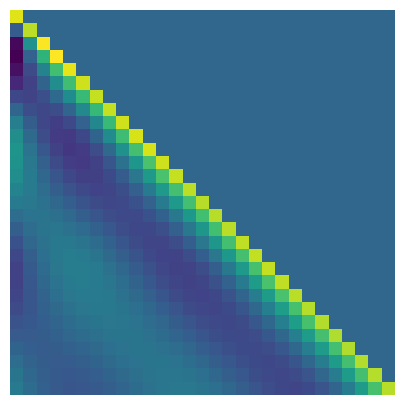

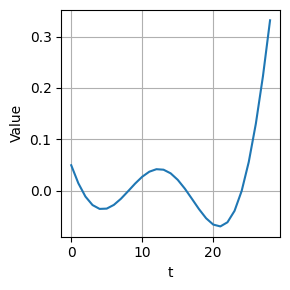

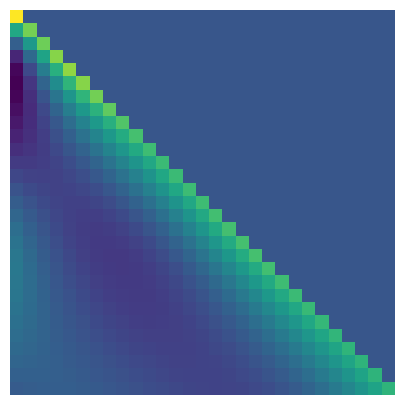

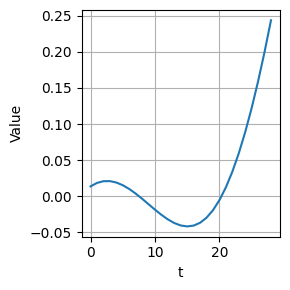

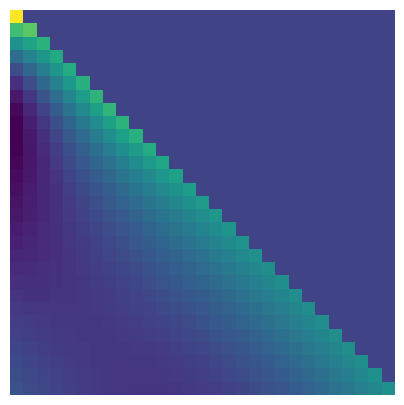

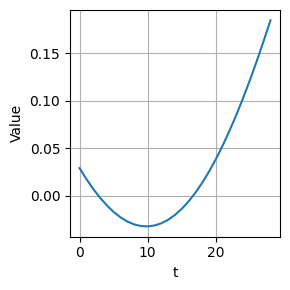

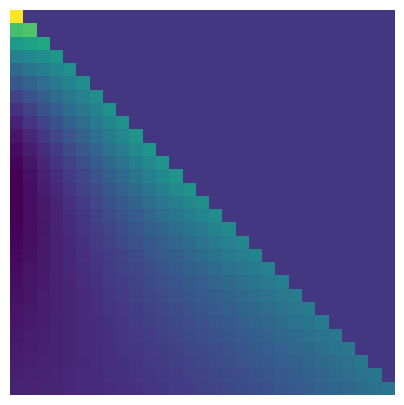

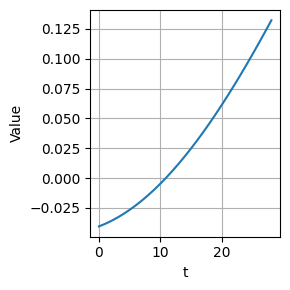

In [5]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
import os


def dot_product(W_i, s_i):
    return jnp.dot(W_i, s_i)

batched_dot_product = jax.vmap(dot_product)

def hermitian_product(x,y):
    return jnp.dot(jnp.conj(x), y)

batched_hermitian_product = jax.vmap(hermitian_product)


@vmap
def batch_block_diag(W):
    return jax.scipy.linalg.block_diag(*W)

def train_and_plot(mu):
    noise = 0.
    dim = 1 #Dimensionality of s_t (1D)
    T = 30
    n = T
    b_ = int(1e3) #Batch size

    def batched_get_seq(b, n=n, dim=dim):
        key = jax.random.PRNGKey(4)

        s_0 = jnp.ones(dim) # / jnp.sqrt(dim)

        s_0 = jnp.tile(s_0, (b, 1))

        sequence = [s_0]

        # Generate random angle between 0 and 2*pi
        #theta = np.random.uniform(0, 2*np.pi, (b,dim))

        theta = np.random.uniform(0, 2*np.pi, (b,dim))

        # Create complex number with modulus 1 and random phase
        W = jnp.exp(1j * theta / mu)
        s = s_0
        for t in range(n):
            eps = jnp.array(np.random.randn(b, dim))
            s = W * s + noise * eps
            sequence.append(s)
        return jnp.array(sequence).transpose((1, 0, 2)), W

    def tensordot(X_T, X):
        return jnp.tensordot(X_T,X, axes=((-1), (0)))


    mask = jnp.tril(jnp.ones((T, T), dtype=jnp.bool_), k=0)

    # Expand the mask to match the batch size
    mask = jnp.expand_dims(mask, axis=0)  # shape: (1, d, d)
    mask = jnp.tile(mask, (b_, 1, 1))  # shape: (b, d, d)
    up_diag = jnp.eye(T, k=1)

    D, W = batched_get_seq(b_, n=n, dim=dim)
    seq = D[:,:-1,:]

    @jax.jit
    def linear_attention(params, s, n_layers=1, layer=1):
        p = params
        attention_scores = jnp.matmul(jnp.conj(s), s.transpose((0, 2, 1)))
        attention_scores = attention_scores * up_diag * p + attention_scores * p * mask
        attended_values = jnp.matmul(attention_scores, s)
        return attended_values

    @jax.jit
    def stack_linear_attention(params_list, s):
        output = jnp.zeros(s.shape)
        p = params_list[-1]
        params = p
        output = output + linear_attention(params, s, n_layers=1, layer=1)
        return output

    @jax.jit
    def loss(params_list, seq, D):
        predictions = stack_linear_attention(params_list, seq)#[:,-1,:]
        y = predictions[:,:-1] - D[:,2:,:]
        return (jnp.mean(jnp.abs(y) ** 2)* dim)

    def return_param_list(num_heads=1, dimension=dim, scale=1e-2, use_full_params=True):
        params_list = []
        p_init = jnp.zeros((T,T))
        params_list += [p_init]
        return params_list

    params_list = return_param_list(num_heads=dim, use_full_params=False)
    grad_loss = jax.jit(jax.grad(loss))

    # Hyperparameters
    learning_rate = 5e-1

    # Initialize the optimizer
    opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

    @jit
    def update(params, opt_state, x, y):
        grads = grad_loss(params, x, y)
        return opt_update(0, grads, opt_state)

    # Training loop
    opt_state = opt_init(params_list)

    losses = []

    seq = D[:,:-1,:]
    targ = D[:,-1,:]

    num_epochs = 100000

    for epoch in range(num_epochs):
        params = get_params(opt_state)
        l = loss(params, seq, D)
        if epoch % 100 == 0:
            print('loss: ', l)
        if len(losses) > 0 and losses[-1] < 1e-3:
           break
        losses.append(l)
        opt_state = update(params, opt_state, seq, D)

    final_params = get_params(opt_state)
    mask_p = jnp.expand_dims(jnp.tril(jnp.ones((T, T), dtype=jnp.bool_), k=0), axis=0)
    p_opt = final_params[-1] * mask_p[0]

    os.makedirs('results/noisy_pe', exist_ok=True)

    np.save('results/noisy_pe/pe_eps_mu_%s.npy' %(mu), p_opt)
    plt.figure(figsize=(5, 5))
    plt.imshow((p_opt)[:-1,:-1])
    plt.axis('off')
    plt.savefig('pe_eps_mu_%s.pdf' %(mu))

    plt.figure(figsize=(3, 3))
    plt.plot((p_opt)[:-1,:-1][-1])
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('proj_pe_eps_mu_%s.pdf' %(mu))


for mu in [50, 100, 200, 300]:
    print('mu = ', mu)
    train_and_plot(mu)
